## This assignment is a backbone implementaion of https://arxiv.org/abs/1812.00328

Through this exercise, you will be familar with:

1. How to backpropagate across a data processing module that uses non-differentiable functions.
2. How to vectorize codes for GPU friendly processing.
3. How to deal with nested optimization in PyTorch possibly making use of gradient stop, such as torch.no_grad().
4. How to mix CNNs with other modules in an end-to-end optimization.

## Do not edit next cell

In [11]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from torch.autograd import Function
import torch.nn as nn
import torch.optim as optim
import math

from google.colab import drive
drive.mount('/content/drive')
#!ls "/content/drive/My Drive"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda:0


## Do not edit next cell

In [0]:
# Define hyper parameters, models, and functions

# A few hyper parameters
delta = 2 # for cost function, acts as smoothing contour
nLines = 50 # number of radial lines
nfilters=16 # number of filters to be used in the network model

# Star pattern computation
def star_pattern():
  theta = np.arange(0.0,2*math.pi,2*math.pi/nLines,dtype=np.float32)
  rad = np.arange(10.0,50.0,1.0)

  RADIUS, THETA = np.meshgrid(rad,theta)

  yx0 = np.reshape([140.0,160.0],(1,2))
  X = yx0[0,1] + RADIUS*np.cos(THETA)
  Y = yx0[0,0] + RADIUS*np.sin(THETA)
  return X,Y


# A few one-time placeholder arrays including the star pattern

X,Y = star_pattern()

X = torch.tensor(X.astype(np.float32)).to(device)
Y = torch.tensor(Y.astype(np.float32)).to(device)

N,M = X.shape

U = torch.zeros((N-1,M,M),dtype=torch.float32).to(device) # value function
I = torch.zeros((N-1,M,M),dtype=torch.int32).to(device) # index function
E = torch.zeros((N,M,M),dtype=torch.float32).to(device) # pairwise energy function
v = -torch.ones((N),dtype=torch.long).to(device) # solution vector

# Dynamic programming to compute indices of the star pattern
# This implements Algorithm 1 from https://arxiv.org/abs/1812.00328
def DynProg(U,I,E,v,warped_image,N,M,delta):

  maxval = torch.max(warped_image)-torch.min(warped_image) + 1.0
  E[:] = maxval

  """
  # Construct E taking into account gradient of warped image on two neiboring radial lines
  for i in range(M):
    jmin = max(0,i-delta)
    jmax = min(i+delta,M-1)
    E[:,i,jmin:jmax+1] = warped_image[0:N,i+1:i+2] - warped_image[0:N,i:i+1] + warped_image[1:N+1,jmin+1:jmax+2] - warped_image[1:N+1,jmin:jmax+1]
  """
  # An example vectorization for constructing E
  # this code uses a for loop with a smaller range (2*delta+1)
  # than the code above using a range M 
  i = torch.arange(0,M,1)
  for d in torch.arange(-delta,delta+1,1):
    j = torch.min(input=torch.max(input=i+d,other=torch.tensor(0)),other=torch.tensor(M-1))
    E.view(N,M*M)[:,M*i+j] = warped_image[0:N,i+1] - warped_image[0:N,i] + warped_image[1:N+1,j+1] - warped_image[1:N+1,j]

  # build value and index functions

  # this is the version with for loops
  for n in range(N-1):
    for i in range(M):
      for k in range(M):
        if n==0:
          U[n,i,k], I[n,i,k] = torch.min(E[0,i,:]+E[1,:,k],0)
        else:
          U[n,i,k], I[n,i,k] = torch.min(U[n-1,i,:]+E[n+1,:,k],0)

  # backtrack to find solution
  val=1e10
  for j in range(M):
    if val > U[N-2,j,j]:
      val = U[N-2,j,j]
      v[0] = j
  v[N-1] = I[N-2,v[0],v[0]]
  for n in np.arange(N-2,0,-1):
    v[n] = I[n-1,v[0],v[n+1]]

  return v

def WarpImage(image,X,Y,height,width):
  height,width = image.shape
  warped_image = torch.nn.functional.grid_sample(image.view(1,1,height,width),torch.stack([2.0*X/width-1.0,2.0*Y/height-1.0],2).unsqueeze(0)).squeeze()

  # increase the borders of the warped image a bit for spatial gradient computation
  warped_image = torch.cat((warped_image,warped_image[:,-1:]),1)
  warped_image = torch.cat((warped_image,warped_image[0:1,:]),0)
  
  return warped_image

# DenseNet type CNN to process input image
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, nfilters, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(nfilters+1, nfilters, kernel_size=3,padding=1)
        self.conv3 = nn.Conv2d(2*nfilters+1, nfilters, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(3*nfilters+1, 1, kernel_size=3,padding=1)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(torch.cat((x,x1),dim=1)))
        x3 = F.relu(self.conv3(torch.cat((x,x1,x2),dim=1)))
        x4 = self.conv4(torch.cat((x,x1,x2,x3),dim=1))
        return x4


## Edit next cell to write your own vectorized dynamic programming

In [0]:
# Your code for vectorized dynamic programming
def DynProg_vectorized(U,I,E,v,warped_image,N,M,delta):
  
  maxval = torch.max(warped_image)-torch.min(warped_image) + 1.0
  E[:] = maxval

  i = torch.arange(0,M,1)

  for d in torch.arange(-delta,delta+1,1):
    j = torch.min(input=torch.max(input=i+d,other=torch.tensor(0)),other=torch.tensor(M-1))
    E.view(N,M*M)[:,M*i+j] = warped_image[0:N,i+1] - warped_image[0:N,i] + warped_image[1:N+1,j+1] - warped_image[1:N+1,j]

  for n in range(N-1):
    if n == 0:
      EE = E[1, :, :].expand(M, M, M).reshape(M*M, M).t()
      LE = E[0, :, :].reshape(1, M*M)

      VMat = (LE + EE).t().reshape(M,M,M)
      U[n, :, :], I[n, :, :] = torch.min(VMat, 1)
    else:
      EE = E[n + 1, :, :].expand(M, M, M).reshape(M*M, M).t()
      LE = U[n - 1, :, :].reshape(1, M*M)

      VMat = (LE + EE).t().reshape(M,M,M)
      U[n, :, :], I[n, :, :] = torch.min(VMat, 1)

  val=1e10
  for j in range(M):
    if val > U[N-2,j,j]:
      val = U[N-2,j,j]
      v[0] = j

  v[N-1] = I[N-2,v[0],v[0]]
  for n in np.arange(N-2,0,-1):
    v[n] = I[n-1,v[0],v[n+1]]

  return v


## Edit next cell to write your own CNN or neural network that approximates dynamic program function

In [0]:
# Your code for approximating CNN or NN for dynamic programming
# input must be warped image and output can be log(softmax) function
class ApproxNet(nn.Module):
  def __init__(self):
    super(ApproxNet, self).__init__()
    # write your code below
    self.conv1 = nn.Conv2d(1, nfilters, kernel_size=3,padding=1)
    self.conv2 = nn.Conv2d(nfilters+1, nfilters, kernel_size=3,padding=1)
    self.conv3 = nn.Conv2d(2*nfilters+1, 1, kernel_size=3,padding=1)


  def forward(self, x):
    # write your code below*
    x1 = F.relu(self.conv1(x))
    x2 = F.relu(self.conv2(torch.cat((x,x1),dim=1)))
    x3 = self.conv3(torch.cat((x,x1,x2),dim=1))

    return F.log_softmax(x3,dim=3)



## Only edit the path to the images in the next cell, nothing else

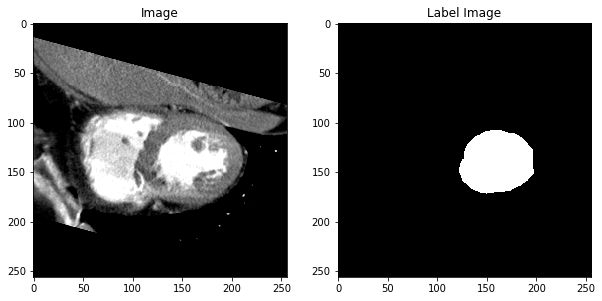

In [15]:
# read image and its label
image = io.imread("/content/drive/My Drive/CMPUT617_2019/Assignment_3/axial_CT_slice.bmp").astype(np.float32)
label_image = io.imread("/content/drive/My Drive/CMPUT617_2019/Assignment_3/axial_CT_slice_label.bmp").astype(np.float32)

image = torch.from_numpy(image).float().to(device)
label_image = torch.from_numpy(label_image).float().to(device)


height, width = label_image.shape # image height and width

%matplotlib inline
fig=plt.figure(figsize=(10, 20))
plt.subplot(1,2,1)
plt.imshow(image.detach().cpu(),cmap='gray')
plt.title("Image")

plt.subplot(1,2,2)
plt.imshow(label_image.detach().cpu(),cmap='gray')
plt.title("Label Image")
plt.show()

## Do not edit next cell

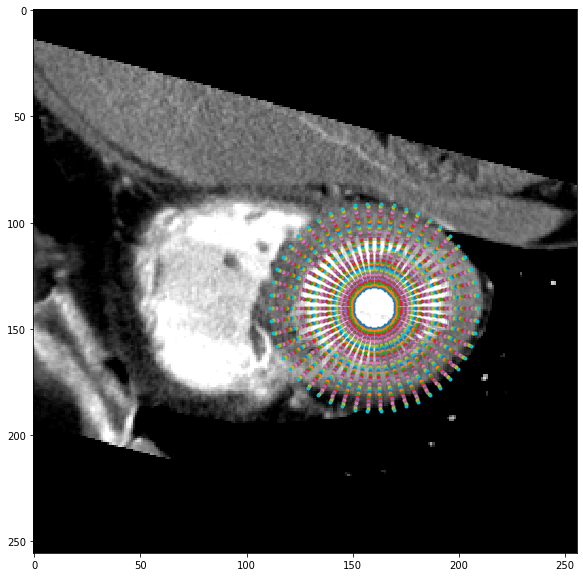

In [16]:
# visualize star pattern on input image
%matplotlib inline
fig=plt.figure(figsize=(10, 10))
plt.imshow(image.detach().cpu(),cmap='gray')
plt.plot(X.cpu().numpy(),Y.cpu().numpy(),'.')
plt.show()


## Do not edit next cell

torch.Size([51, 41])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


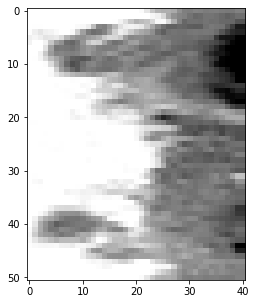

In [17]:
# Visualize warped image
warped_image = WarpImage(image,X,Y,height,width)
print(warped_image.shape)

%matplotlib inline
fig=plt.figure(figsize=(5, 5))
plt.imshow(warped_image.detach().cpu(),cmap='gray')
plt.show()

## Change "DynProg" to "DynProg_vectorized" to test your vectorized DP code. Do not edit anything else in the next cell.



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


tensor([27, 27, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 24, 25,
        26, 27, 27, 29, 28, 29, 27, 25, 23, 24, 24, 24, 24, 23, 23, 22, 22, 22,
        22, 22, 22, 21, 21, 22, 23, 24, 25, 25, 26, 28, 28, 27],
       device='cuda:0')


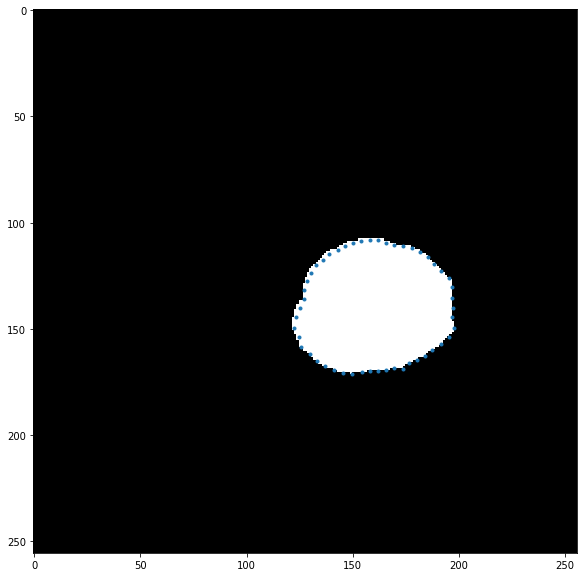

In [18]:
# test dynamic programming and create target label
with torch.no_grad():
  warped_label_image = WarpImage(label_image,X,Y,height,width)
  # target = DynProg(U,I,E,v,warped_label_image,N,M,delta).clone() # clone to not corrupt it
  target = DynProg_vectorized(U,I,E,v,warped_label_image,N,M,delta).clone() # clone to not corrupt it

  

print(target)

target_x=np.zeros((N))
target_y=np.zeros((N))
for n in range(N):
  target_x[n] = X[n,target[n]]  
  target_y[n] = Y[n,target[n]]

%matplotlib inline
fig=plt.figure(figsize=(10, 10))
plt.imshow(label_image.detach().cpu(),cmap='gray')
plt.plot(target_x,target_y,'.')
plt.show()

## Edit next cell to write your optimization (training) code. This section should implement Algorithm 2 from https://arxiv.org/abs/1812.00328. To get credit for this portion, on Google colaboratory with the GPU option this training code must run within 3 minutes.

In [19]:
# Your training code. This should implement Algorithm 2 from https://arxiv.org/abs/1812.00328
# You might have to make use of torch.no_grad() or something equivalent in relevant places

learning_rate = 1e-3 # an example value
sig = 1 # an example value, this is for jittering input to approximating net and dynamic program
#sig = 0.1
# write your code here
# To get credit for this portion, on Google colaboratory with the GPU option thgis training code must run within 2 to 3 minutes
import time





starttime = time.time()




network = Net().cuda()
approx_network = ApproxNet().cuda()


network_optim = optim.Adam(network.parameters(), lr=learning_rate)
approx_network_optim = optim.Adam(approx_network.parameters(), lr=learning_rate)
loss_func = torch.nn.NLLLoss()

im_input = image.view(1, 1, height, width).to(device, dtype=torch.float)

gt_target = target


for i in range(500):
  im_map = network(im_input).squeeze()

  warped_map = WarpImage(im_map, X, Y, height, width)

  height_warp, width_warp = warped_map.shape

  with torch.no_grad():
    target_temp = DynProg_vectorized(U,I,E,v,warped_map + sig*torch.randn(height_warp, width_warp).to(device, dtype=torch.float32) ,N,M,delta).clone()
    #target_temp = DynProg_vectorized(U,I,E,v,warped_map ,N,M,delta).clone()
  
  warped_map = warped_map + sig*torch.randn(height_warp, width_warp).to(device, dtype=torch.float32)

  for j in range(10):
    approx_target = approx_network( warped_map.view(1, 1, height_warp, width_warp) ).squeeze()
    #approx_target = approx_network( warped_map.view(1, 1, height_warp, width_warp) ).squeeze()
    approx_target = approx_target[0:-1, :]



    approx_loss = loss_func(approx_target, target_temp)

    #if i % 100 == 0:
      #print("Approx Train Epoch:", i, "   loss:", approx_loss.item())

    approx_network_optim.zero_grad()
    approx_loss.backward(retain_graph=True)
    approx_network_optim.step()

  output_map = approx_network(warped_map.view(1, 1, height_warp, width_warp) ).squeeze()
  output_map = output_map[0:-1, :]

  fin_loss = loss_func(output_map, gt_target)

  if i % 100 == 0:
    print("Train Epoch:", i, "   loss:", fin_loss.item())

  network_optim.zero_grad()
  fin_loss.backward(retain_graph=True)
  network_optim.step()

print("Train Epoch:", i, "   loss:", fin_loss.item())

endtime = time.time()

print("total time:", endtime - starttime)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Train Epoch: 0    loss: 4.402523517608643
Train Epoch: 100    loss: 1.0615489482879639
Train Epoch: 200    loss: 0.28559067845344543
Train Epoch: 300    loss: 0.045670367777347565
Train Epoch: 400    loss: 0.04801679775118828
Train Epoch: 499    loss: 0.007381572853773832
total time: 79.09273219108582


## Do not edit next cell

tensor([27, 27, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 24, 25,
        26, 27, 27, 29, 28, 29, 27, 25, 23, 24, 24, 24, 24, 23, 23, 22, 22, 22,
        22, 22, 22, 21, 21, 22, 23, 24, 25, 25, 26, 28, 28, 27],
       device='cuda:0')
tensor([27, 27, 29, 28, 26, 24, 23, 22, 21, 22, 20, 20, 20, 20, 21, 23, 24, 25,
        26, 27, 27, 29, 28, 29, 27, 25, 23, 24, 24, 24, 24, 23, 23, 22, 22, 22,
        22, 22, 22, 21, 21, 22, 23, 24, 25, 25, 26, 28, 28, 27],
       device='cuda:0')


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


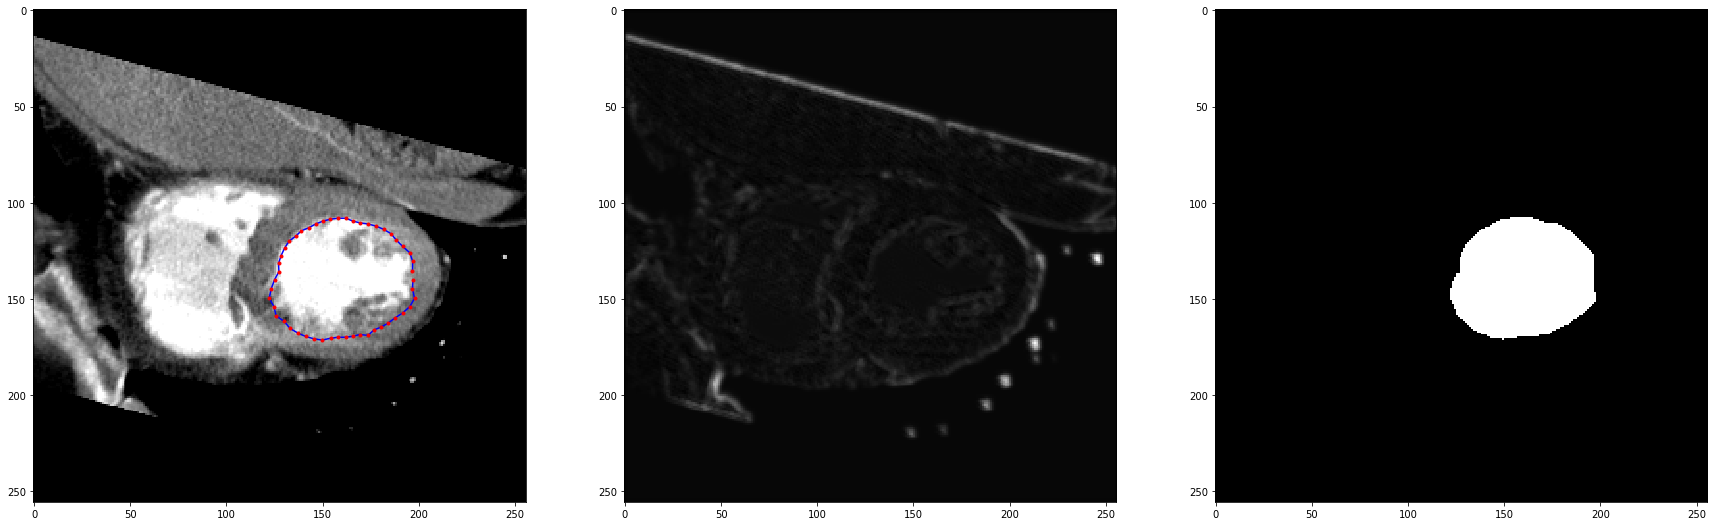

In [20]:
# showtime!

im_out = network(image.view(1,1,height,width)).squeeze()
warped_image = WarpImage(im_out,X,Y,height,width)
ind = DynProg_vectorized(U,I,E,v,warped_image,N,M,delta).clone()
print(ind)
print(target)
x=np.zeros((N))
y=np.zeros((N))
for n in range(N):
  x[n] = X[n,ind[n]]  
  y[n] = Y[n,ind[n]]

%matplotlib inline
fig=plt.figure(figsize=(30, 30))
plt.subplot(1,3,1)
plt.imshow(image.view(height,width).detach().cpu().numpy(),cmap='gray')
plt.plot(x,y,'b')
plt.plot(target_x,target_y,'r.')

plt.subplot(1,3,2)
plt.imshow(im_out.view(height,width).detach().cpu().numpy(),cmap='gray')

plt.subplot(1,3,3)
plt.imshow(label_image.view(height,width).detach().cpu().numpy(),cmap='gray')

plt.show()

The performance is certainly the advantage of applying deep learning network for left ventricle segmentation. The novel architecture of UNet makes the network has the ability to learn the local and global information. Also with the help of GPU implementation and the dynamic programming, the segmentation step is done in real-time.


However, there are also several disadvantages.
+ **Boundary Problem**: The number of points on a radial line have significant influcence for segmenting the boundary of ventricle. Without enough points, the boundary of ventricle can't be matched correctly. Moreover, to the best of my knowledge, the convolutional operation unavoidably smoothens the boundary between objects. Therefore, when we apply the convolutional network for segmenting objects, like left ventricle, the pixels nearing the boundary is highly possible to be labeled incorrectly. Especially for the objects include some sharp parts, like the trees (<font color="#666600">the yellow part</font>) on the following picture. It is obvious that the network is not working well in the boundary between the trees and the sky. In this condition,  some traditional clustering algorithms based on the color of pixels are supposed to be better than the deep learning network.
![](https://www.mathworks.com/help/examples/deeplearning_shared/win64/SemanticSegmentationUsingDeepLearningExample_04.png)

+ **Heat Map**: The output of the UNet is a heat map rather than a labeled image. Therefore, a further processing step, such as thresholding, is required to generate a labeled mask. In this assignment, the radial lines and dynamic programming are used. However, there is no guarantee that this further step is differentiable and can be optimized by gradient descent. For example, the dynamic programming procedure is undifferentiable. In order to train the network, the developers thus have to find a way to make this step become differentiable, which is the main reason that the approximation network is proposed for training in this assignment.

+ **Computational Cost**: Finally, I'd like to discuss the computational cost. Currently, the segmentation is done in real-time for a single image. However, in future work, we may have videos instead of images. In this condition, the computational cost increases heavily, which is too complex to be accepted, even with the help of GPU implementation. Personally, I think it is the main reason that most of the video segmentation network focuses on scenes segmentation which is closely related to image segmentation.






